In [1]:
!pip install tf-nightly

     |████████████████████████████████| 519.3MB 30kB/s 
     |████████████████████████████████| 460kB 53.8MB/s 
     |████████████████████████████████| 3.0MB 54.1MB/s 


In [2]:
import tensorflow as tf
print("Tensor Flow Verion: " + tf.__version__)
tf.test.gpu_device_name()

Tensor Flow Verion: 2.2.0-dev20200422


'/device:GPU:0'

In [4]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"mingzhehu","key":"92235045fd85f95ca75fb5844cc352ff"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /content/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/kermany2018 -p /content

mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}
100% 10.8G/10.8G [04:17<00:00, 55.5MB/s]
100% 10.8G/10.8G [04:17<00:00, 45.2MB/s]


In [0]:
!unzip \*.zip

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.layers import ELU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import numpy as np
import os
import cv2
from os import listdir
from os.path import isfile, join
import re
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model
import matplotlib.image as mpimg
%matplotlib inline

**Load the model**

In [70]:
cd /content/drive/My Drive/Detecting Retina Damage from Speckle Noise Polluted OCT-Retinal Images

/content/drive/My Drive/Detecting Retina Damage from Speckle Noise Polluted OCT-Retinal Images


In [0]:
model = tf.keras.models.load_model('VGG16/saved_model/VGG16_model')

**Add noise to test data**

Noise free

In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [73]:
cd /content

/content


In [0]:
train_data_dir = 'OCT2017 /train'
validation_data_dir = 'OCT2017 /test'

In [0]:
num_classes = 4
img_rows, img_cols = 224, 224
batch_size = 16
nb_train_samples = 83484
nb_validation_samples = 968

In [76]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [77]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 3s 54ms/step - loss: 0.2430 - accuracy: 0.9401

Test result: 94.008 loss: 0.243


In [0]:
validation_datagen = ImageDataGenerator(rescale=1./255)

In [79]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


In [0]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()} 
classes = list(class_labels.values())

In [0]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)

Confusion Matrix
[[235   3   4   0]
 [  3 214   1  24]
 [  9   1 219  13]
 [  0   0   0 242]]


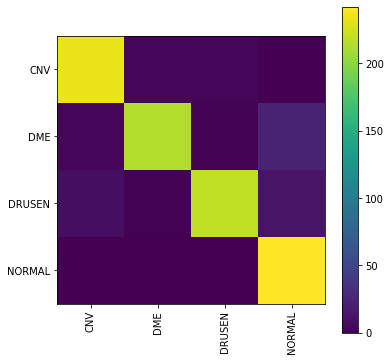

In [82]:
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

In [83]:
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Classification Report
              precision    recall  f1-score   support

         CNV       0.95      0.97      0.96       242
         DME       0.98      0.88      0.93       242
      DRUSEN       0.98      0.90      0.94       242
      NORMAL       0.87      1.00      0.93       242

    accuracy                           0.94       968
   macro avg       0.94      0.94      0.94       968
weighted avg       0.94      0.94      0.94       968



Amplitude = 1

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=1):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [86]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [87]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 156ms/step - loss: 0.2940 - accuracy: 0.9225

Test result: 92.252 loss: 0.294


In [88]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[230   4   7   1]
 [  3 204   1  34]
 [  6   2 220  14]
 [  0   0   0 242]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.96      0.95      0.96       242
         DME       0.97      0.84      0.90       242
      DRUSEN       0.96      0.91      0.94       242
      NORMAL       0.83      1.00      0.91       242

    accuracy                           0.93       968
   macro avg       0.93      0.93      0.93       968
weighted avg       0.93      0.93      0.93       968



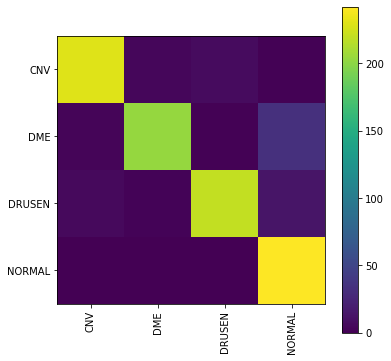

In [89]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 2

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=2):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [92]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [93]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 159ms/step - loss: 0.3404 - accuracy: 0.9008

Test result: 90.083 loss: 0.340


In [94]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[225   9   7   1]
 [  3 196   0  43]
 [  8   3 210  21]
 [  0   0   1 241]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.95      0.93      0.94       242
         DME       0.94      0.81      0.87       242
      DRUSEN       0.96      0.87      0.91       242
      NORMAL       0.79      1.00      0.88       242

    accuracy                           0.90       968
   macro avg       0.91      0.90      0.90       968
weighted avg       0.91      0.90      0.90       968



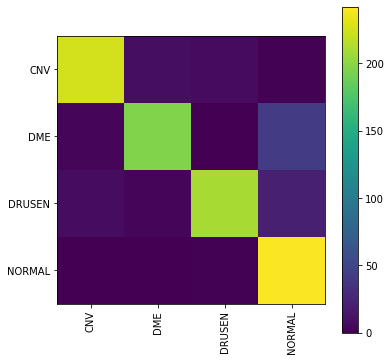

In [95]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 3

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=3):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [98]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [99]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 157ms/step - loss: 0.3653 - accuracy: 0.8853

Test result: 88.533 loss: 0.365


In [100]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[223  16   2   1]
 [  3 194   1  44]
 [ 19   4 197  22]
 [  0   0   1 241]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.91      0.92      0.92       242
         DME       0.91      0.80      0.85       242
      DRUSEN       0.98      0.81      0.89       242
      NORMAL       0.78      1.00      0.88       242

    accuracy                           0.88       968
   macro avg       0.89      0.88      0.88       968
weighted avg       0.89      0.88      0.88       968



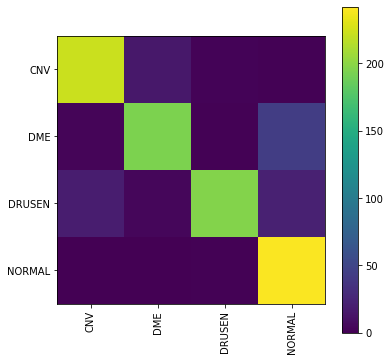

In [101]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 4

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=4):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [104]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [105]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 155ms/step - loss: 0.4049 - accuracy: 0.8543

Test result: 85.434 loss: 0.405


In [106]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[219  21   1   1]
 [  4 191   0  47]
 [ 31  10 177  24]
 [  0   0   1 241]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.86      0.90      0.88       242
         DME       0.86      0.79      0.82       242
      DRUSEN       0.99      0.73      0.84       242
      NORMAL       0.77      1.00      0.87       242

    accuracy                           0.86       968
   macro avg       0.87      0.86      0.85       968
weighted avg       0.87      0.86      0.85       968



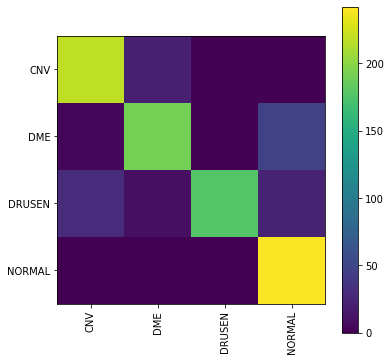

In [107]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 5

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=5):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [110]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [111]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 9s 155ms/step - loss: 0.4907 - accuracy: 0.8068

Test result: 80.682 loss: 0.491


In [112]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[212  26   2   2]
 [  6 197   3  36]
 [ 61  10 134  37]
 [  0   5   1 236]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.76      0.88      0.81       242
         DME       0.83      0.81      0.82       242
      DRUSEN       0.96      0.55      0.70       242
      NORMAL       0.76      0.98      0.85       242

    accuracy                           0.80       968
   macro avg       0.83      0.80      0.80       968
weighted avg       0.83      0.80      0.80       968



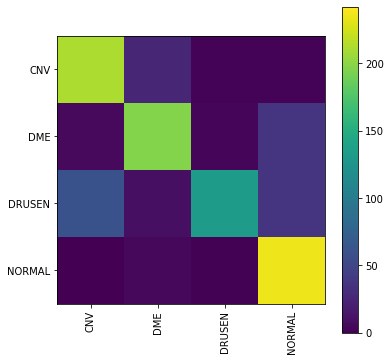

In [113]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 6

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=6):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [116]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [117]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 157ms/step - loss: 0.6226 - accuracy: 0.7324

Test result: 73.244 loss: 0.623


In [118]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[206  33   1   2]
 [  5 192   3  42]
 [ 97  15  93  37]
 [  0  18   4 220]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.67      0.85      0.75       242
         DME       0.74      0.79      0.77       242
      DRUSEN       0.92      0.38      0.54       242
      NORMAL       0.73      0.91      0.81       242

    accuracy                           0.73       968
   macro avg       0.77      0.73      0.72       968
weighted avg       0.77      0.73      0.72       968



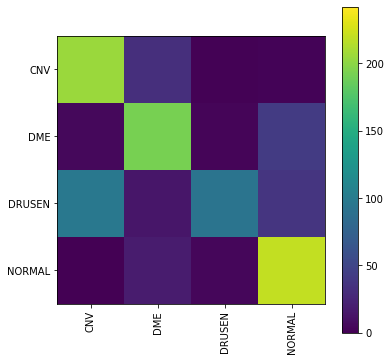

In [119]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 7

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=7):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [122]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [123]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 158ms/step - loss: 0.7404 - accuracy: 0.6942

Test result: 69.421 loss: 0.740


In [124]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[196  38   2   6]
 [  9 186   2  45]
 [101  25  69  47]
 [  3  31  13 195]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.63      0.81      0.71       242
         DME       0.66      0.77      0.71       242
      DRUSEN       0.80      0.29      0.42       242
      NORMAL       0.67      0.81      0.73       242

    accuracy                           0.67       968
   macro avg       0.69      0.67      0.64       968
weighted avg       0.69      0.67      0.64       968



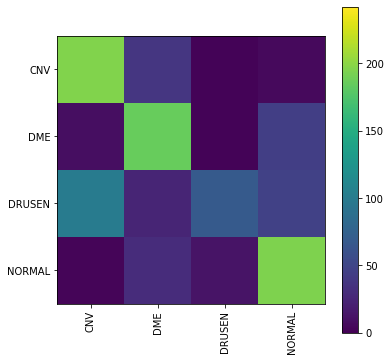

In [125]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))

Amplitude = 8

In [0]:
from skimage.util import random_noise

def AddSpeckle(img, level=8):
  img = img/255.0
  noise = level * np.random.normal(0, 0.01 ** 0.5, img.shape)
  img_speckled = img + img * noise
  out = np.clip(img_speckled, 0, 1.0)
  return out

In [0]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)

In [128]:
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')

Found 968 images belonging to 4 classes.


In [129]:
scores = model.evaluate_generator(validation_generator,steps=nb_validation_samples // batch_size+1, verbose=1)
print('\nTest result: %.3f loss: %.3f' %(scores[1]*100,scores[0]))

61/61 [==============================] - 10s 158ms/step - loss: 0.9181 - accuracy: 0.6271

Test result: 62.707 loss: 0.918


In [130]:
validation_datagen = ImageDataGenerator(preprocessing_function=AddSpeckle)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 968 images belonging to 4 classes.


Confusion Matrix
[[193  37   0  12]
 [ 11 185   2  44]
 [116  21  49  56]
 [ 12  37  11 182]]
Classification Report
              precision    recall  f1-score   support

         CNV       0.58      0.80      0.67       242
         DME       0.66      0.76      0.71       242
      DRUSEN       0.79      0.20      0.32       242
      NORMAL       0.62      0.75      0.68       242

    accuracy                           0.63       968
   macro avg       0.66      0.63      0.60       968
weighted avg       0.66      0.63      0.60       968



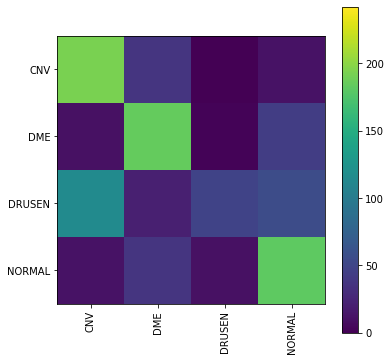

In [131]:
y_pred = model.predict_generator(validation_generator, nb_validation_samples//batch_size + 1)
y_pred_label = np.argmax(y_pred, axis=1)
print("Confusion Matrix")
print(confusion_matrix(validation_generator.classes, y_pred_label))

plt.figure(figsize=(6,6))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred_label)
plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
plt.clim(0, 242)
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)
print('Classification Report')
print(classification_report(validation_generator.classes, y_pred_label, target_names=classes))